---
title: "强化学习专题 - 时序差分方法"
date: 2025-06-06T23:22:00+08:00
author: "Liu Zheng"
tags: ["笔记", "实验", "AI", "强化学习"]
categories: "实验笔记"
---

# 时序差分方法

时序差分（TD）学习是强化学习中的一类核心方法，它结合了蒙特卡洛（MC）方法和动态规划（DP）的思想 。时序差分方法能够在不了解环境完整模型的情况下，通过从经验中学习来更新价值函数 。

**蒙特卡洛方法：**

蒙特卡洛方法确实存在“每次观测的样本方差可能很大”的问题。这是因为每次训练迭代（即每条轨迹或每个回合）都是从头到尾完整的进行，计算一个完整的回报（G）来更新Q值。由于轨迹本身的随机性，即使从同一个状态-动作对开始，不同轨迹的回报也可能差异很大。这种高方差导致了Q值更新的“抖动剧烈”，需要很长时间才能学到准确的平均回报估计。

**时序差分（TD）方法：**

时序差分方法通过“自举（bootstrapping）”机制来解决这个问题。“自举”是指TD方法不是等待整个回合结束，而是在每一步就进行更新。它使用“实际的即时奖励”加上“对未来折扣奖励的估计”来更新当前状态-动作对的价值。这个“估计”是基于当前学习到的价值函数本身。这种“每一步”的更新方式，结合了对未来价值的“估计”（而非真实观察），使得价值的传播更为迅速且不易受单次完整轨迹的剧烈波动影响。因此，TD方法使得整个价值评估过程“更加平滑”，并能更快地收敛。

时序差分（TD）方法是强化学习中用于估计价值函数的核心技术，主要包括以下几种常见算法：

- **TD(0)**：最基础的时序差分方法，每一步用当前奖励和下一个状态的价值估计来更新当前状态的价值。
- **SARSA**：一种 on-policy TD 控制算法，更新 Q 值时依赖于实际采取的下一个动作（见下文实现）。
- **Q-Learning**：一种 off-policy TD 控制算法，更新 Q 值时使用下一个状态所有动作中的最大 Q 值（见下文实现）。
- **Expected SARSA**：在更新时对所有可能动作的 Q 值加权平均，权重为当前策略下各动作的概率。
- **TD(λ)**：引入资格迹（eligibility trace），结合多步 TD 更新，兼顾 MC 和 TD(0) 的优点。

这些方法广泛应用于无模型强化学习任务，能够在与环境交互的过程中高效地学习最优策略。

**SARSA 与 Q-Learning 的场景比较：**

- **SARSA（on-policy）** 更适合需要“安全探索”或对策略收敛路径有要求的场景。例如，在存在较大风险或惩罚的环境中，SARSA 能学习到更为保守的策略，避免过度冒险。
- **Q-Learning（off-policy）** 更适合追求最终最优策略的场景。由于其更新方式总是朝向当前估计的最优动作，收敛速度较快，但在高风险环境下可能导致策略过于激进。

实际应用中，若环境安全性要求高或探索阶段需规避风险，建议优先采用 SARSA；若更关注最终性能且环境允许大胆探索，则 Q-Learning 更为高效。

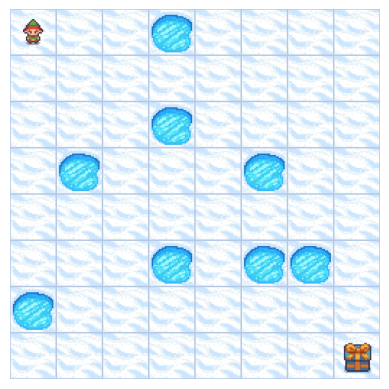

In [1]:
import gymnasium
import matplotlib.pyplot
import numpy
from collections import defaultdict
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

SIZE = 8

ENV = gymnasium.make("FrozenLake-v1", desc=generate_random_map(SIZE), map_name=f"{SIZE}x{SIZE}", is_slippery=False, render_mode="rgb_array")
ENV.reset()

image = ENV.render()

matplotlib.pyplot.imshow(image)
matplotlib.pyplot.axis("off")
matplotlib.pyplot.show()

## 1. Q-Learning 算法

Q-Learning 是一种无模型的强化学习算法，通过与环境的交互，不断更新状态-动作价值函数（Q函数），以学习最优策略。其核心思想是利用贝尔曼最优方程，通过“自举”方式在每一步对 Q 值进行更新。Q-Learning 具有如下特点：

- 不需要环境的转移概率模型；
- 通过探索与利用（如 $\epsilon$-greedy 策略）平衡学习效率与最优性；
- 每次更新仅依赖于当前状态、动作、奖励和下一个状态的最大 Q 值。

下方代码实现了 Q-Learning 算法在 FrozenLake 环境中的应用，并可视化学习结果与策略表现。

> **算法实现：**
> 
> $
> \begin{array}{l}
> input:\  \text{MDP}\ M = \langle S, s_0, A, P_a(s' \mid s), r(s,a,s')\rangle\\
> output:\ \text{Q-function}\ Q\\[2mm]
> \text{Initialise}\ Q\ \text{arbitrarily; e.g.,}\ Q(s,a) \leftarrow 0\ \text{for all}\ s\ \text{and}\ a\\[2mm]
> repeat \\
> \quad\quad s \leftarrow\ \text{the first state in episode}\ e\\
> \quad\quad repeat\ \text{(for each step in episode}\ e \text{)}\\
> \quad\quad\quad\quad \text{Select action}\ a\ \text{to apply in}\ s;\\
> \quad\quad\quad\quad\quad\quad \text{e.g. using}\ Q\ \text{and a multi-armed bandit algorithm such as}\ \epsilon\text{-greedy}\\
> \quad\quad\quad\quad \text{Execute action}\ a\ \text{in state}\ s\\
> \quad\quad\quad\quad \text{Observe reward}\ r\ \text{and new state}\ s'\\
> \quad\quad\quad\quad \delta \leftarrow r + \gamma \cdot \max_{a'} Q(s',a') - Q(s,a)\\
> \quad\quad\quad\quad Q(s,a) \leftarrow Q(s,a) + \alpha \cdot \delta\\
> \quad\quad\quad\quad s \leftarrow s'\\
> \quad\quad until\ s\ \text{is the last state of episode}\ e\ \text{(a terminal state)}\\
> until\ Q\ \text{converges}
> \end{array}
> $

In [2]:
class QLMDP:
    def __init__(self, env):
        self.env = env
        self.S = range(env.observation_space.n)
        self.A = range(env.action_space.n)
        self.Qt = defaultdict(lambda: numpy.zeros(env.action_space.n))

    def choose_action(self, s, eps):
        if numpy.random.rand() < eps:
            return self.env.action_space.sample()
        return numpy.argmax(self.Qt[s])

    def build(self, alpha=0.1, gamma=0.99, epis=10000, theta=1e-6, eps=1.0):
        for n in range(epis):
            s, _ = self.env.reset()
            done = False
            step = 0
            while not done:
                a = self.choose_action(s, numpy.clip(epis - n / epis * eps, 0.01, 1.0))
                sn, Rsa, done, _, _ = self.env.step(a)
                delta = Rsa + gamma * numpy.max(self.Qt[sn]) - self.Qt[s][a]
                self.Qt[s][a] += alpha * delta
                s = sn
                step += 1

    def decision(self, s):
        return int(numpy.argmax(self.Qt[s])), numpy.argmax(self.Qt[s])

    def evaluate(self, figure):
        image = self.env.render()
        subplot = figure.add_subplot(1, 2, 1)
        subplot.axis("off")
        subplot.imshow(image)
        ih, iw, _ = image.shape
        ch, cw = ih // SIZE, iw // SIZE  # Cell height and width
        s, _ = self.env.reset()
        for i in range(SIZE):
            for j in range(SIZE):
                Qs0 = self.Qt[i * SIZE + j][0]
                Qs1 = self.Qt[i * SIZE + j][1]
                Qs2 = self.Qt[i * SIZE + j][2]
                Qs3 = self.Qt[i * SIZE + j][3]
                subplot.text(j * cw + cw - 24, i * ch + 12, f"L:{Qs0:.2f}", fontsize=6, ha="center", va="center", fontfamily="Sarasa Mono SC")
                subplot.text(j * cw + cw - 24, i * ch + 24, f"D:{Qs1:.2f}", fontsize=6, ha="center", va="center", fontfamily="Sarasa Mono SC")
                subplot.text(j * cw + cw - 24, i * ch + 36, f"R:{Qs2:.2f}", fontsize=6, ha="center", va="center", fontfamily="Sarasa Mono SC")
                subplot.text(j * cw + cw - 24, i * ch + 48, f"U:{Qs3:.2f}", fontsize=6, ha="center", va="center", fontfamily="Sarasa Mono SC")
        while True:
            a, _ = self.decision(s)
            s, _, done, truncated, _ = self.env.step(a)
            if done or truncated:
                break
            subplot.plot(s % SIZE * cw + cw // 2, s // SIZE * ch + ch // 2, marker="o", markersize=8, color="red", alpha=0.5)

    def simulation(self, epis=100):
        count = 0
        for episode in range(epis):
            s, _ = self.env.reset()
            done = False
            truncated = False
            R = 0
            while not done and not truncated:
                a, _ = self.decision(s)
                s, Rs, done, truncated, _ = self.env.step(a)
                R += Rs
                if done and Rs == 1.0:  # In FrozenLake, reward is 1.0 only upon reaching 'G'
                    count += 1
        success_rate = count / epis * 100
        print(f"\nRunning {epis} episodes using the optimal policy:")
        print(f"Success Rate: {success_rate:.2f}%")

## 2. SARSA 算法

SARSA（State-Action-Reward-State-Action）是一种基于时序差分的强化学习算法，与 Q-Learning 不同，SARSA 在更新 Q 值时使用的是实际采取的下一个动作的 Q 值，而不是最大 Q 值。其更新公式为：

$$
Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r + \gamma Q(s', a') - Q(s, a) \right]
$$

主要特点：

- SARSA 是“on-policy”方法，更新依赖于当前策略下实际选择的动作；
- 能更好地反映当前策略的表现，适合策略随训练动态调整的场景；
- 在探索性较强时，学习到的策略更为保守。

**算法实现：**

> $
> \begin{array}{l}
> input:\  \text{MDP}\ M = \langle S, s_0, A, P_a(s' \mid s), r(s,a,s')\rangle\\
> output:\ \text{Q-function}\ Q\\[2mm]
> \text{Initialise}\ Q\ \text{arbitrarily; e.g.,}\ Q(s,a) \leftarrow 0\ \text{for all}\ s\ \text{and}\ a\\[2mm]
> repeat \\
> \quad\quad s \leftarrow\ \text{the first state in episode}\ e\\
> \quad\quad \text{Select action}\ a\ \text{to apply in}\ s;\\
> \quad\quad\quad\quad \text{e.g. using}\ Q\ \text{and a multi-armed bandit algorithm such as}\ \epsilon\text{-greedy}\\
> \quad\quad repeat\ \text{(for each step in episode}\ e \text{)}\\
> \quad\quad\quad\quad \text{Execute action}\ a\ \text{in state}\ s\\
> \quad\quad\quad\quad \text{Observe reward}\ r\ \text{and new state}\ s'\\
> \quad\quad\quad\quad \text{Select action}\ a\ \text{to apply in}\ s';\\
> \quad\quad\quad\quad\quad\quad \text{e.g. using}\ Q\ \text{and a multi-armed bandit algorithm such as}\ \epsilon\text{-greedy}\\
> \quad\quad\quad\quad \delta \leftarrow r + \gamma \cdot  Q(s',a') - Q(s,a)\\
> \quad\quad\quad\quad Q(s,a) \leftarrow Q(s,a) + \alpha \cdot \delta\\
> \quad\quad\quad\quad s \leftarrow s'\\
> \quad\quad\quad\quad a \leftarrow a'\\
> \quad\quad until\ s\ \text{is the last state of episode}\ e\ \text{(a terminal state)}\\
> until\ Q\ \text{converges}
> \end{array}
> $

SARSA 适用于需要“安全探索”或对策略收敛路径有要求的场景。

In [3]:
class SAMDP:
    def __init__(self, env):
        self.env = env
        self.S = range(env.observation_space.n)
        self.A = range(env.action_space.n)
        self.Qt = defaultdict(lambda: numpy.zeros(env.action_space.n))

    def choose_action(self, s, eps):
        if numpy.random.rand() < eps:
            return self.env.action_space.sample()
        return numpy.argmax(self.Qt[s])

    def build(self, alpha=0.1, gamma=0.99, epis=10000, theta=1e-6, eps=1.0):
        for n in range(epis):
            s, _ = self.env.reset()
            a = self.choose_action(s, numpy.clip(epis - n / epis * eps, 0.01, 1.0))
            done = False
            step = 0
            while not done:
                sn, Rsa, done, _, _ = self.env.step(a)
                an = self.choose_action(sn, numpy.clip(epis - n / epis * eps, 0.01, 1.0))
                delta = Rsa + gamma * self.Qt[sn][an] - self.Qt[s][a]
                self.Qt[s][a] += alpha * delta
                s = sn
                a = an
                step += 1

    def decision(self, s):
        return int(numpy.argmax(self.Qt[s])), numpy.argmax(self.Qt[s])

    def evaluate(self, figure):
        image = self.env.render()
        subplot = figure.add_subplot(1, 2, 2)
        subplot.axis("off")
        subplot.imshow(image)
        ih, iw, _ = image.shape
        ch, cw = ih // SIZE, iw // SIZE  # Cell height and width
        s, _ = self.env.reset()
        for i in range(SIZE):
            for j in range(SIZE):
                Qs0 = self.Qt[i * SIZE + j][0]
                Qs1 = self.Qt[i * SIZE + j][1]
                Qs2 = self.Qt[i * SIZE + j][2]
                Qs3 = self.Qt[i * SIZE + j][3]
                subplot.text(j * cw + cw - 24, i * ch + 12, f"L:{Qs0:.2f}", fontsize=6, ha="center", va="center", fontfamily="Sarasa Mono SC")
                subplot.text(j * cw + cw - 24, i * ch + 24, f"D:{Qs1:.2f}", fontsize=6, ha="center", va="center", fontfamily="Sarasa Mono SC")
                subplot.text(j * cw + cw - 24, i * ch + 36, f"R:{Qs2:.2f}", fontsize=6, ha="center", va="center", fontfamily="Sarasa Mono SC")
                subplot.text(j * cw + cw - 24, i * ch + 48, f"U:{Qs3:.2f}", fontsize=6, ha="center", va="center", fontfamily="Sarasa Mono SC")
        while True:
            a, _ = self.decision(s)
            s, _, done, truncated, _ = self.env.step(a)
            if done or truncated:
                break
            subplot.plot(s % SIZE * cw + cw // 2, s // SIZE * ch + ch // 2, marker="o", markersize=8, color="red", alpha=0.5)

    def simulation(self, epis=100):
        count = 0
        for episode in range(epis):
            s, _ = self.env.reset()
            done = False
            truncated = False
            R = 0
            while not done and not truncated:
                a, _ = self.decision(s)
                s, Rs, done, truncated, _ = self.env.step(a)
                R += Rs
                if done and Rs == 1.0:  # In FrozenLake, reward is 1.0 only upon reaching 'G'
                    count += 1
        success_rate = count / epis * 100
        print(f"\nRunning {epis} episodes using the optimal policy:")
        print(f"Success Rate: {success_rate:.2f}%")


Running 100 episodes using the optimal policy:
Success Rate: 100.00%

Running 100 episodes using the optimal policy:
Success Rate: 100.00%


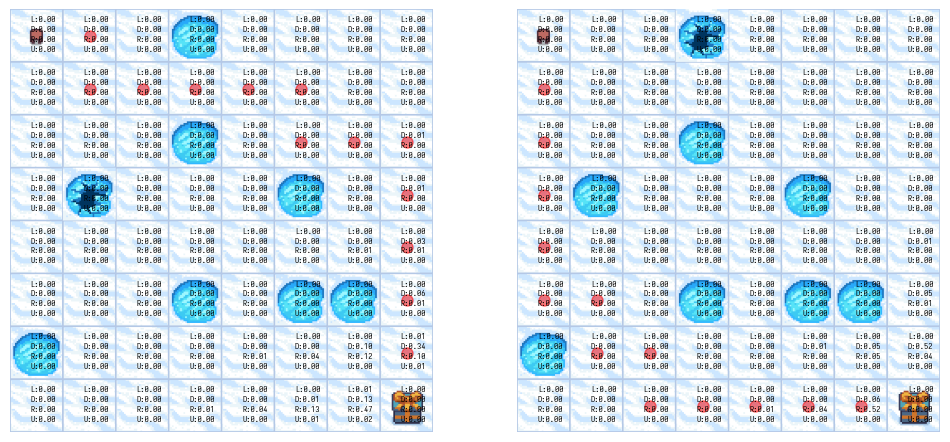

In [4]:
figure = matplotlib.pyplot.figure(figsize=(12, 6))

INSTANCE1 = QLMDP(ENV)
INSTANCE1.build()
INSTANCE1.evaluate(figure)
INSTANCE1.simulation(100)

INSTANCE2 = SAMDP(ENV)
INSTANCE2.build()
INSTANCE2.evaluate(figure)
INSTANCE2.simulation(100)

matplotlib.pyplot.show()